# TensorBoard Lab: Formula 1 Fastest Lap Prediction 🏎️

A comprehensive machine learning lab demonstrating **TensorBoard** for monitoring, visualizing, and debugging neural network training using real **Formula 1 race data**.  

In [53]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
# Clear any logs from previous runs
!rm -rf ./logs/

Load & Prepare F1 Dataset

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Enable TensorFlow debugger logging
tf.debugging.experimental.enable_dump_debug_info(
    './logs/', tensor_debug_mode='FULL_HEALTH', circular_buffer_size=-1
)

print("TensorFlow version:", tf.__version__)

INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: ./logs/, tensor debug mode: FULL_HEALTH)
TensorFlow version: 2.20.0


In [57]:
df = pd.read_csv("data/results.csv") 

# Preview
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.3,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [58]:
df['podium'] = (df['positionOrder'] <= 3).astype(int)

In [59]:
features = ['grid', 'laps', 'driverId', 'constructorId']
X = df[features]
y = df['podium']

In [ ]:
# Feature selection & preprocessing
# Target: 'time' (race finish time)
# Inputs: 'grid', 'laps', 'constructorId', 'driverId', 'positionOrder'

# Drop rows with missing time
results = results.dropna(subset=['time'])

# Convert time to seconds
def time_to_seconds(t):
    try:
        parts = t.split(':')
        if len(parts) == 3:
            h, m, s = parts
            return int(h)*3600 + int(m)*60 + float(s)
        elif len(parts) == 2:
            m, s = parts
            return int(m)*60 + float(s)
        else:
            return float(parts[0])
    except:
        return np.nan

results['time_seconds'] = results['time'].apply(time_to_seconds)
results = results.dropna(subset=['time_seconds'])

# Select features
num_features = ['grid', 'laps']
cat_features = ['constructorId', 'driverId', 'positionOrder']

X_num = results[num_features].fillna(0).values
X_cat = results[cat_features].astype(str)  # convert to string for one-hot

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = ohe.fit_transform(X_cat)

# Scale numeric features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine numeric + categorical
X = np.hstack([X_num_scaled, X_cat_encoded])
y = results['time_seconds'].values


In [ ]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
# Setup TensorBoard callback
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [67]:
# Build model
model = keras.models.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,137 (59.13 KB)

 Trainable params: 15,137 (59.13 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=128,
    callbacks=[tensorboard_callback]
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3409980.7500 - mae: 873.0439 - val_loss: 454392.8750 - val_mae: 243.5229
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 224433.2500 - mae: 155.0270 - val_loss: 183919.6719 - val_mae: 129.5127
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151474.5625 - mae: 127.9793 - val_loss: 177254.2812 - val_mae: 127.5667
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135999.7344 - mae: 121.4976 - val_loss: 173264.3125 - val_mae: 125.6160
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 129079.9531 - mae: 118.2369 - val_loss: 173152.3750 - val_mae: 126.9256
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123924.2188 - mae: 115.7949 - val_loss: 171593.6875 - val_mae: 126.8520
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120349.1797 - mae: 114.2204 - val_loss: 169935.7500 - val_mae: 126.1088
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116712.5938 - mae: 113.0001 - v

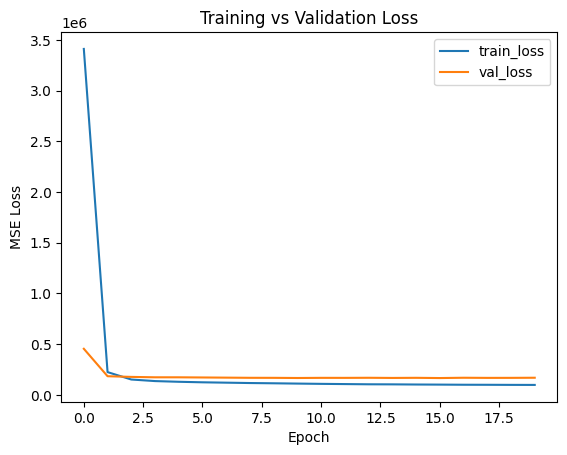

In [69]:
# Plot training & validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [71]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=128,
    callbacks=[tensorboard_callback] 
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97625.9219 - mae: 104.6874 - val_loss: 170215.7188 - val_mae: 127.1775
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96692.8359 - mae: 104.3147 - val_loss: 169457.0938 - val_mae: 127.9427
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96450.3203 - mae: 104.3179 - val_loss: 174216.0938 - val_mae: 128.3697
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96190.2031 - mae: 104.1933 - val_loss: 167300.7344 - val_mae: 126.6945
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95357.8906 - mae: 103.7458 - val_loss: 174349.1719 - val_mae: 128.2285
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95217.0625 - mae: 103.5808 - val_loss: 170879.3594 - val_mae: 127.6064
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94632.1250 - mae: 103.4472 - val_loss: 173633.4219 - val_mae: 128.1581
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94579.1406 - mae: 103.2484 - val_loss: 

In [72]:
import os

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir, exist_ok=True)


In [73]:
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,   # log weights every epoch
    update_freq='epoch',
)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/ --port 6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
#  🔟 Launch TensorBoard
%tensorboard --logdir logs/


Reusing TensorBoard on port 6008 (pid 88385), started 0:02:02 ago. (Use '!kill 88385' to kill it.)

In [ ]:
#http://localhost:6008

A brief overview of the visualizations created in this example and the dashboards (tabs in top navigation bar) where they can be found:

Scalars show how the loss and metrics change with every epoch. You can use them to also track training speed, learning rate, and other scalar values. Scalars can be found in the Time Series or Scalars dashboards.
Graphs help you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly. Graphs can be found in the Graphs dashboard.
Histograms and Distributions show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way. Histograms can be found in the Time Series or Histograms dashboards. Distributions can be found in the Distributions dashboard.
Breakdown of the Debugger Interface The Debugger Dashboard on the Tensorboard consists of five main components:

Alerts: This top-left section contains a list of alert events detected by the debugger in the debug data from the instrumented TensorFlow program. Each alert indicates a certain anomaly that warrants attention. In our case, this section highlights 499 NaN/∞ events with a salient pink-red color. This confirms our suspicion that the model fails to learn because of the presence of NaNs and/or infinities in its internal tensor values.
Python Execution Timeline: This is the upper half of the top-middle section. It presents the full history of the eager execution of ops and graphs. Each box of the timeline is marked by the initial letter of the op or graph’s name. We can navigate this timeline by using the navigation buttons and the scrollbar above the timeline.
Graph Execution: Located at the top-right corner of the GUI, this section will be central to our debugging task. It contains a history of all the floating-type tensors computed inside graphs, i.e., the ones compiled by @tf-functions.
Stack Trace: The bottom-right section, shows the stack trace of the creation of every single operation on the graph.
Source Code: The bottom-left section, highlights the source code corresponding to each operation on the graph.
 